# Investigating the Practicality of Adversarial Evasion Attacks on Network Intrusion Detection (UNSW-NB15)

## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import copy
import time as time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2

#!pip install adversarial-robustness-toolbox >/dev/null
import os,sys
sys.path.append(os.path.dirname('../adversarial-robustness-toolbox/'))
from art.attacks.evasion import FastGradientMethod, BasicIterativeMethod, DeepFool, SaliencyMapMethod, CarliniL2Method, CarliniLInfMethod, CarliniL0Method
from art.classifiers import PyTorchClassifier

%matplotlib inline

pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

## Data pre-processing

### Download and import the dataset

In [2]:
# Import the training and testing datasets from .CSV to Pandas DataFrames
#features = ['1 Duration', '2 Protocol-type : ', '3 Service : ', '4 Flag : ', '5 Src-bytes', '6 Dst-bytes', '7 Land', '8 Wrong-fragment', '9 Urgent', '10 Hot', '11 Num-failed-logins', '12 Logged-in', '13 Num-compromised', '14 Root-shell', '15 Su-attempted', '16 Num-root', '17 Num-file-creations', '18 Num-shells', '19 Num-access-files', '20 Num-outbound-cmds', '21 Is-host-login', '22 Is-guest-login', '23 Count', '24 Srv-count', '25 Serror-rate', '26 Srv-serror-rate', '27 Rerror-rate', '28 Srv-rerror-rate', '29 Same-srv-rate', '30 Diff-srv-rate', '31 Srv-diff-host-rate', '32 Dst-host-count', '33 Dst-host-srv-count', '34 Dst-host-same-srv-rate', '35 Dst-host-diff-srv-rate', '36 Dst-host-same-src-port-rate', '37 Dst-host-srv-diff-host-rate', '38 Dst-host-serror-rate', '39 Dst-host-srv-serror-rate', '40 Dst-host-rerror-rate', '41 Dst-host-srv-rerror-rate', '42 Attack_type', '43 Difficulty']
df_training = pd.read_csv('./UNSW_NB15_training-set.csv')
df_testing = pd.read_csv('./UNSW_NB15_testing-set.csv')
# Stack the training and test sets
data = pd.concat([df_training, df_testing], axis=0)

### Remove unsued features

In [3]:
# Drop the column id
data.drop('id', inplace=True, axis=1)
# Drop the column attack_cat
data.drop('attack_cat', inplace=True, axis=1)

### Remove inconsistent values

In [4]:
# is_ftp_login is a binary feature, but few instances hold the value 2 and 4, we remove them
data = data[data['is_ftp_login'] != 2]
data = data[data['is_ftp_login'] != 4]



### One Hot Encoding

In [5]:
# One Hot Encode the 3 first nominal attributes and drop them
for i in ['state', 'service', 'proto']:
    # Create the One Hot Encode DataFrame
    dum = pd.get_dummies(data[i])
    # Insert into the dataset DataFrame by Series
    for column_name in list(dum.columns):
        new_name = str(i)+' : '+column_name
        data.insert(1, new_name, dum[column_name])
        data[new_name] = data[new_name].astype('int64')
    # Drop the old attribute's column
    data.drop(i, inplace=True, axis=1)

### Normalization

In [6]:
# Min-Max normalization on the non binary features
# The min and max values are computed on the training set
min = data[:df_training.shape[0]].min()
max = data[:df_training.shape[0]].max()
for i in ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst']:
    data[i] = (data[i] - min[i]) / (max[i] - min[i])

### Split the dataset

In [7]:
# Split training and testing sets
df_training = data[:df_training.shape[0]]    
df_testing = data[df_training.shape[0]:]


### Format the data

In [8]:
# Get NumPy arrays from DataFrames
nd_training = df_training.values
nd_testing = df_testing.values

In [9]:
# Separating arguments (x) from lables (y)
x_train = nd_training[:, :-1]
y_train = nd_training[:, -1]
x_test = nd_testing[:, :-1]
y_test = nd_testing[:, -1]

In [10]:
# Make a copy of the data set as NumPy arrays
x_train_np = x_train.copy()
y_train_np = y_train.copy()
x_test_np = x_test.copy()
y_test_np = y_test.copy()

In [11]:
# Convert from numpy array to torch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).long()

## Model training

### Neural network model

In [12]:
class Network(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc3 = nn.Linear(hidden_size[1], output_size)

    def forward(self, x, softmax=False): 
        a = self.fc3(F.relu(self.fc2(F.relu(self.fc1(x.float())))))
        if softmax:
            y_pred = F.softmax(a, dim=1)
        else:
            y_pred = a

        return y_pred

### Accuracy function

In [13]:
def evaluate(predictions, real):
    n_correct = torch.eq(predictions, real).sum().item()
    accuracy = n_correct / len(predictions)
    return accuracy * 100

### Statistics function

In [14]:
def stat_model(model, x_train, y_train, x_test, y_test):
    _, predictions_train = model(x_train, softmax=True).max(dim=1)
    accuracy_train = evaluate(predictions=predictions_train.long(), real=y_train)

    _, predictions_test = model(x_test, softmax=True).max(dim=1)
    accuracy_test = evaluate(predictions=predictions_test.long(), real=y_test)
    
    print("Final Training Accuracy: {0:.4f}%\nFinal Testing Accuracy : {1:.4f}%"
          .format(accuracy_train, accuracy_test))
    # Move the tensors back to CPU
    label_test_final = y_test.cpu().numpy()
    predictions_test_final = predictions_test.cpu().numpy()
    report = classification_report(label_test_final, predictions_test_final)
    print("Classification Report :")
    print(report)

### Model training

In [15]:
# Initialising the model
input_size=x_train.shape[1]
hidden_size=[256,256]
output_size=2
model = Network(input_size, hidden_size, output_size)

# Setting device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Training on : {}".format(device))

# Transfering model and data to GPU
model = model.to(device)
x_train = x_train.to(device)
y_train = y_train.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# Setting the Loss function and Adam learning rate
criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer = optim.Adam(model.parameters(), lr=lr)

# Variables to store the best performences (weights and accuracy)
best_model_weights = copy.deepcopy(model.state_dict())
best_accuracy = 0.0

# DataFrame for the learning curve plot
trace = pd.DataFrame(columns=['epoch', 'train_acc', 'test_acc'])
# Iterrating on the dataset
since = time.time()
for epoch in range(1000+1):
    # Forward pass
    y_pred = model(x_train)
    _, predictions = y_pred.max(dim=1)
    # Compute accuracy
    accuracy_train = evaluate(predictions=predictions.long(), real=y_train)
    # Compute loss
    loss = criterion(y_pred, y_train)

    # Testing model on the test set
    if epoch%10 == 0:
        _, predictions_test = model(x_test, softmax=True).max(dim=1)
        accuracy_test = evaluate(predictions=predictions_test.long(), real=y_test)
        # Keep track of the accuracies for the learning curve
        trace = trace.append([{'epoch':epoch,
                                'train_acc':accuracy_train,
                                'test_acc':accuracy_test}])
        # Save the best model's accuracy and parameters
        if accuracy_test > best_accuracy:
            best_accuracy = accuracy_test
            best_model_weights = copy.deepcopy(model.state_dict())
        # Displap statistics
        if epoch%100 == 0:
            time_elapsed = time.time() - since
            print("epoch: {0:4d} | loss: {1:.4f} | Train accuracy: {2:.4f}% | Test accuracy: {3:.4f}% [{4:.4f}%] | Running for : {5:.0f}m {6:.0f}s"
                  .format(epoch,
                          loss,
                          accuracy_train,
                          accuracy_test,
                          best_accuracy,
                          time_elapsed // 60,
                          time_elapsed % 60))

    # Zero all gradients
    optimizer.zero_grad()
    # Backward pass
    loss.backward()
    # Update weights
    optimizer.step()

# Compute the training time
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Training on : cuda
epoch:    0 | loss: 0.6925 | Train accuracy: 44.9910% | Test accuracy: 31.9870% [31.9870%] | Running for : 0m 1s
epoch:  100 | loss: 0.1187 | Train accuracy: 95.5242% | Test accuracy: 89.0814% [90.5285%] | Running for : 0m 3s
epoch:  200 | loss: 0.1023 | Train accuracy: 95.8412% | Test accuracy: 87.8590% [90.5285%] | Running for : 0m 5s
epoch:  300 | loss: 0.0881 | Train accuracy: 96.4145% | Test accuracy: 88.7574% [90.5285%] | Running for : 0m 6s
epoch:  400 | loss: 0.0857 | Train accuracy: 96.5712% | Test accuracy: 88.8800% [90.5285%] | Running for : 0m 8s
epoch:  500 | loss: 0.0917 | Train accuracy: 96.1837% | Test accuracy: 90.0379% [90.5285%] | Running for : 0m 9s
epoch:  600 | loss: 0.0790 | Train accuracy: 96.7570% | Test accuracy: 88.2417% [90.5285%] | Running for : 0m 11s
epoch:  700 | loss: 0.0776 | Train accuracy: 96.7461% | Test accuracy: 88.0883% [90.5285%] | Running for : 0m 13s
epoch:  800 | loss: 0.0711 | Train accuracy: 97.0789% | Test accuracy: 88.7

### Learning curve and performances

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Final Training Accuracy: 94.1335%
Final Testing Accuracy : 90.5285%
Classification Report :
              precision    recall  f1-score   support

           0       0.79      0.96      0.87     55994
           1       0.98      0.88      0.93    119321

    accuracy                           0.91    175315
   macro avg       0.88      0.92      0.90    175315
weighted avg       0.92      0.91      0.91    175315



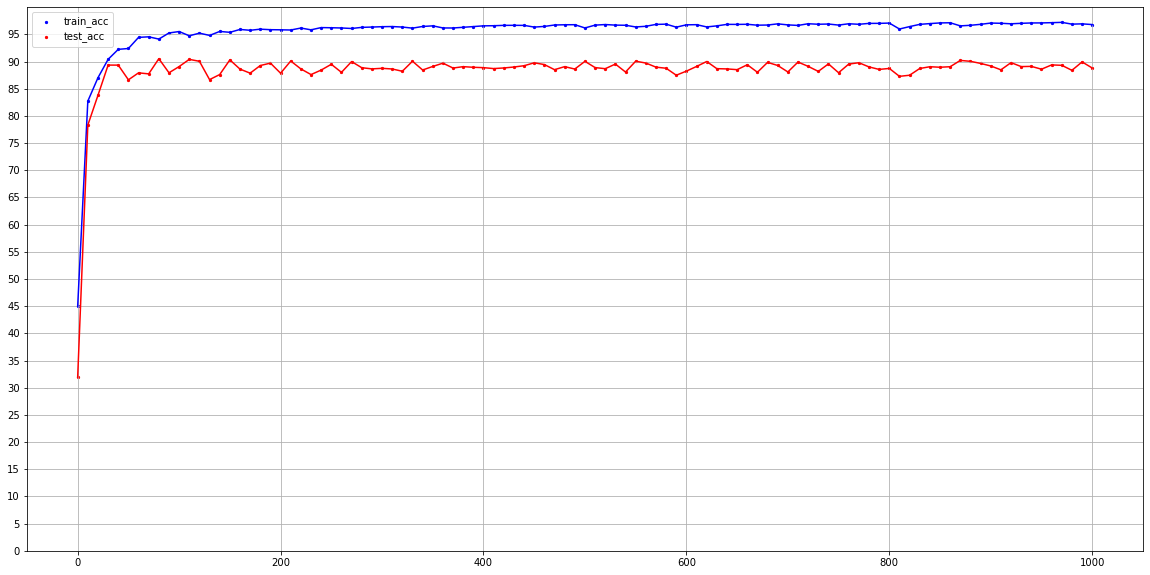

In [16]:
# Draw the learning curve
plt.figure(figsize=(20, 10))
plt.scatter(data=trace, x='epoch', y='train_acc', c="b", s=5)
plt.scatter(data=trace, x='epoch', y='test_acc', c="r", s=5)
plt.plot(trace['epoch'], trace['train_acc'], c="b")
plt.plot(trace['epoch'], trace['test_acc'], c="r")
plt.ylim((0, 100))
plt.yticks(np.arange(0, 100, 5))
plt.grid()
plt.legend()
plt.savefig("learning_curve.eps", format="eps", bbox_inches='tight')

# Loading the best weights and displaying the best model's performances
model.load_state_dict(best_model_weights)
stat_model(model, x_train, y_train, x_test, y_test)

### Save/Load model

In [15]:
torch.save(model.state_dict(), "./model.pytorch")
model.load_state_dict(torch.load("./model.pytorch"))

Training on : cuda


<All keys matched successfully>

## Adversarial Attacks

### Statistics table

In [16]:
adv_feat_stats = pd.DataFrame(index=df_training.columns[:-1])

adv_results = pd.DataFrame(index=['Accuracy', 
                                  'Mean perturbed features   [Mean L0]', 
                                  'Max perturbed features    [Max  L0]', 
                                  'Mean Euclidiant distance  [Mean L2]', 
                                  'Max Euclidiant distance   [Max  L2]', 
                                  'Mean Maximum perturbation [Mean Li]', 
                                  'Max Maximum perturbation  [Max  Li]'])

adv_inv = pd.DataFrame(index=['Invalid value range',
                              'Invalid binary values',
                              'Invalid class belonging'])

### Lp norms function

In [17]:
def adv_norms(x_test_cpu, adversarial_examples_cpu):
    mean_l0 = np.mean(np.sum(x_test_cpu != adversarial_examples_cpu, axis=1))
    max_l0 = np.max(np.sum(x_test_cpu != adversarial_examples_cpu, axis=1))
    mean_l2 = np.mean(np.sum(np.power(x_test_cpu - adversarial_examples_cpu, 2), axis=1, keepdims=True))
    max_l2 = np.max(np.sum(np.power(x_test_cpu - adversarial_examples_cpu, 2), axis=1, keepdims=True))
    mean_li = np.mean(np.max(np.abs(x_test_cpu - adversarial_examples_cpu), axis=1, keepdims=True))
    max_li = np.max(np.max(np.abs(x_test_cpu - adversarial_examples_cpu), axis=1, keepdims=True))
    return [mean_l0, max_l0, mean_l2, max_l2, mean_li, max_li]

### Invalidity criteria function

In [18]:
def adv_criteria(x_test_cpu, adversarial_examples_cpu):
    # Verify value ranges
    min = x_test_cpu.min(axis=1, keepdims=True)
    max = x_test_cpu.max(axis=1, keepdims=True)
    adv_range = (adversarial_examples_cpu < min) | (adversarial_examples_cpu > max)
    adv_range = adv_range.any(axis=1, keepdims=True)
    adv_range = adv_range.sum(axis=0)

    # Binary values
    binary_feat_ind = list(range(1,158)) + [190, 195]
    adv_bin = adversarial_examples_cpu[:, binary_feat_ind]
    adv_bin = (adv_bin != 1) & ( adv_bin != 0)
    adv_bin = adv_bin.any(axis=1, keepdims=True)
    adv_bin = adv_bin.sum(axis=0)

    # Multi class
    adv1 = adversarial_examples_cpu[:, 1:134] != 0 #proto
    adv1 = adv1.astype(int).sum(axis=1, keepdims=True) != 1
    adv1 = adv1.sum(axis=1, keepdims=True)

    adv2 = adversarial_examples_cpu[:, 134:147] != 0 #service
    adv2 = adv2.astype(int).sum(axis=1, keepdims=True) != 1
    adv2 = adv2.sum(axis=1, keepdims=True)

    adv3 = adversarial_examples_cpu[:, 147:158] != 0 #state
    adv3 = adv3.astype(int).sum(axis=1, keepdims=True) != 1
    adv3 = adv3.sum(axis=1, keepdims=True)

    adv_cat = adv1 | adv2 | adv3
    adv_cat = adv_cat.sum(axis=0)

    return [adv_range[0]*100/x_test.shape[0], adv_bin[0]*100/x_test.shape[0], adv_cat[0]*100/x_test.shape[0]]

### Extract attack samples

In [19]:
positive_examples = df_testing[df_testing['label'] == 1].values
x_test = torch.from_numpy((positive_examples[:, :-1])).float()
y_test = torch.from_numpy((positive_examples[:, -1])).float()
x_test = x_test.to(device)
y_test = y_test.to(device)

### Define the model in ART

In [92]:
# Apply the PyTorch wrapper
classifier = PyTorchClassifier(model=model, loss=criterion, optimizer=optimizer, input_shape=input_size, nb_classes=output_size)

### Clean Data
Unmodified attacks simples from the dataset.

In [24]:
_, predictions_clean = model(x_test, softmax=True).max(dim=1)
accuracy_clean = evaluate(predictions=predictions_clean.long(), real=y_test)

attack='Clean'

# Exporting the clean positive examples in a .csv file
pd.DataFrame(np.hstack((x_test.cpu().numpy(),y_test.cpu().numpy().reshape(y_test.shape[0], 1))), columns=data.columns).to_csv("clean_examples.csv")

x_test_cpu = np.array(x_test.cpu())
adv_results[attack] = [accuracy_clean] + adv_norms(x_test_cpu, x_test_cpu)
adv_inv[attack] = adv_criteria(x_test_cpu, x_test_cpu)

print(adv_results[attack])
print(adv_inv[attack])

Accuracy                               88.00295
Mean perturbed features   [Mean L0]     0.00000
Max perturbed features    [Max  L0]     0.00000
Mean Euclidiant distance  [Mean L2]     0.00000
Max Euclidiant distance   [Max  L2]     0.00000
Mean Maximum perturbation [Mean Li]     0.00000
Max Maximum perturbation  [Max  Li]     0.00000
Name: Clean, dtype: float64
Invalid value range        0.0
Invalid binary values      0.0
Invalid class belonging    0.0
Name: Clean, dtype: float64


### Fast Gradient Sign Method
*Goodfellow et al. (2015) "Explaining and Harnessing Adversarial Examplse"*

In [96]:
# Creating the adversarial examples crafter
adversarial_crafter = FastGradientMethod(classifier,
                                         norm=np.inf,
                                         eps=0.1,
                                         targeted=False,
                                         num_random_init=0,
                                         batch_size=128,
                                         )
# Generating the adversarial examples
adversarial_examples = adversarial_crafter.generate(x=x_test.cpu())

adversarial_examples = torch.from_numpy(adversarial_examples).float()
adversarial_examples = adversarial_examples.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
stat_model(model, x_test, y_test, adversarial_examples, y_test)

adversarial_examples_cpu = np.array(adversarial_examples.cpu())
x_test_cpu = np.array(x_test.cpu())

_, predictions_adv = model(adversarial_examples, softmax=True).max(dim=1)
accuracy_adv = evaluate(predictions=predictions_adv.long(), real=y_test)
attack = 'FGSM'
adv_results[attack] = [accuracy_adv] + adv_norms(x_test_cpu, adversarial_examples_cpu)
adv_inv[attack] = adv_criteria(x_test_cpu, adversarial_examples_cpu)

# Exporting the adversarial examples in a .csv file
pd.DataFrame(np.hstack((adversarial_examples_cpu,y_test.cpu().reshape(y_test.shape[0], 1))), columns=data.columns).to_csv("adversarial_examples_FGSM.csv")

# Saving the statistics in a table
perturbation = np.abs(adversarial_examples_cpu - x_test_cpu)
adv_feat_stats[attack] = ((perturbation > 10e-6).sum(axis=0) / perturbation.shape[0]) * 100

print(adv_results[attack])
print(adv_inv[attack])

Final Training Accuracy: 88.0030%
Final Testing Accuracy : 11.9970%
Classification Report :
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.12      0.21    119321

    accuracy                           0.12    119321
   macro avg       0.50      0.06      0.11    119321
weighted avg       1.00      0.12      0.21    119321



Accuracy                                11.997050
Mean perturbed features   [Mean L0]    196.000000
Max perturbed features    [Max  L0]    196.000000
Mean Euclidiant distance  [Mean L2]      1.959999
Max Euclidiant distance   [Max  L2]      1.959998
Mean Maximum perturbation [Mean Li]      0.100000
Max Maximum perturbation  [Max  Li]      0.100000
Name: FGSM, dtype: float64
Invalid value range        100.0
Invalid binary values      100.0
Invalid class belonging    100.0
Name: FGSM, dtype: float64


### Basic Iterative Method

*Kurakin et al. (2016) "Adversarial examples in the physical world"*


In [97]:
# Creating the adversarial examples crafter
adversarial_crafter = BasicIterativeMethod(classifier, 
                                           eps=0.1, 
                                           eps_step=0.001,
                                           max_iter=100, 
                                           targeted=False, 
                                           batch_size=128)
# Generating the adversarial examples
adversarial_examples = adversarial_crafter.generate(x=x_test.cpu())

adversarial_examples = torch.from_numpy(adversarial_examples).float()
adversarial_examples = adversarial_examples.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
stat_model(model, x_test, y_test, adversarial_examples, y_test)

adversarial_examples_cpu = np.array(adversarial_examples.cpu())
x_test_cpu = np.array(x_test.cpu())

_, predictions_adv = model(adversarial_examples, softmax=True).max(dim=1)
accuracy_adv = evaluate(predictions=predictions_adv.long(), real=y_test)
attack = 'BIM'
adv_results[attack] = [accuracy_adv] + adv_norms(x_test_cpu, adversarial_examples_cpu)
adv_inv[attack] = adv_criteria(x_test_cpu, adversarial_examples_cpu)

# Exporting the adversarial examples in a .csv file
pd.DataFrame(np.hstack((adversarial_examples_cpu,y_test.cpu().reshape(y_test.shape[0], 1))), columns=data.columns).to_csv("adversarial_examples_BIM.csv")

# Saving the statistics in a table
perturbation = np.abs(adversarial_examples_cpu - x_test_cpu)
adv_feat_stats[attack] = ((perturbation > 10e-6).sum(axis=0) / perturbation.shape[0]) * 100

print(adv_results[attack])
print(adv_inv[attack])

Final Training Accuracy: 88.0030%
Final Testing Accuracy : 11.9970%
Classification Report :
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.12      0.21    119321

    accuracy                           0.12    119321
   macro avg       0.50      0.06      0.11    119321
weighted avg       1.00      0.12      0.21    119321



Accuracy                                11.997050
Mean perturbed features   [Mean L0]    195.980850
Max perturbed features    [Max  L0]    196.000000
Mean Euclidiant distance  [Mean L2]      1.803510
Max Euclidiant distance   [Max  L2]      1.939689
Mean Maximum perturbation [Mean Li]      0.100000
Max Maximum perturbation  [Max  Li]      0.100000
Name: BIM, dtype: float64
Invalid value range        100.0
Invalid binary values      100.0
Invalid class belonging    100.0
Name: BIM, dtype: float64


### DeepFool
*Moosavi-Dezfooli et al (2016) "DeepFool: a simple and accurate method to fool deep neural networks"*

In [98]:
# Creating the adversarial examples crafter
adversarial_crafter = DeepFool(classifier, 
                               max_iter=100, 
                               epsilon=1e-6, 
                               nb_grads=10, 
                               batch_size=128)

# Generating the adversarial examples
adversarial_examples = adversarial_crafter.generate(x=x_test.cpu())

adversarial_examples = torch.from_numpy(adversarial_examples).float()
adversarial_examples = adversarial_examples.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
stat_model(model, x_test, y_test, adversarial_examples, y_test)

adversarial_examples_cpu = np.array(adversarial_examples.cpu())
x_test_cpu = np.array(x_test.cpu())

_, predictions_adv = model(adversarial_examples, softmax=True).max(dim=1)
accuracy_adv = evaluate(predictions=predictions_adv.long(), real=y_test)
attack = 'DF'
adv_results[attack] = [accuracy_adv] + adv_norms(x_test_cpu, adversarial_examples_cpu)            
adv_inv[attack] = adv_criteria(x_test_cpu, adversarial_examples_cpu)

# Exporting the adversarial examples in a .csv file
pd.DataFrame(np.hstack((adversarial_examples_cpu,y_test.cpu().reshape(y_test.shape[0], 1))), columns=data.columns).to_csv("adversarial_examples_DF.csv")

# Saving the statistics in a table
perturbation = np.abs(adversarial_examples_cpu - x_test_cpu)
adv_feat_stats[attack] = ((perturbation > 10e-6).sum(axis=0) / perturbation.shape[0]) * 100

print(adv_results[attack])
print(adv_inv[attack])

Final Training Accuracy: 88.0030%
Final Testing Accuracy : 12.0943%
Classification Report :
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.12      0.22    119321

    accuracy                           0.12    119321
   macro avg       0.50      0.06      0.11    119321
weighted avg       1.00      0.12      0.22    119321



Accuracy                                12.094267
Mean perturbed features   [Mean L0]    195.995759
Max perturbed features    [Max  L0]    196.000000
Mean Euclidiant distance  [Mean L2]      0.009494
Max Euclidiant distance   [Max  L2]      0.240325
Mean Maximum perturbation [Mean Li]      0.016242
Max Maximum perturbation  [Max  Li]      0.160390
Name: DF, dtype: float64
Invalid value range        100.0
Invalid binary values      100.0
Invalid class belonging    100.0
Name: DF, dtype: float64


### Carlini & Wagner L2 Attack
*Carlini et al. (2017) "Towards Evaluating the Robustness of Neural Networks"*

In [99]:
# Creating the adversarial examples crafter
adversarial_crafter = CarliniL2Method(classifier,
                                      confidence=0.0,
                                      targeted=False,
                                      learning_rate=0.01,
                                      binary_search_steps=10,
                                      max_iter=10,
                                      initial_const=0.01,
                                      max_halving=5,
                                      max_doubling=5,
                                      batch_size=128)
# Generating the adversarial examples
adversarial_examples = adversarial_crafter.generate(x=x_test.cpu())

# The transformation to tanh space introduce some small perturbation, we remove it to get the exact statistics
adversarial_examples = pd.DataFrame(adversarial_examples)
adversarial_examples[(np.abs(adversarial_examples - x_test_cpu) < 10e-6)] = x_test_cpu
adversarial_examples = adversarial_examples.values

adversarial_examples = torch.from_numpy(adversarial_examples).float()
adversarial_examples = adversarial_examples.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
stat_model(model, x_test, y_test, adversarial_examples, y_test)

adversarial_examples_cpu = np.array(adversarial_examples.cpu())
x_test_cpu = np.array(x_test.cpu())

_, predictions_adv = model(adversarial_examples, softmax=True).max(dim=1)
accuracy_adv = evaluate(predictions=predictions_adv.long(), real=y_test)
attack = 'CW2'
adv_results[attack] = [accuracy_adv] + adv_norms(x_test_cpu, adversarial_examples_cpu)
adv_inv[attack] = adv_criteria(x_test_cpu, adversarial_examples_cpu)

# Exporting the adversarial examples in a .csv file
pd.DataFrame(np.hstack((adversarial_examples_cpu,y_test.cpu().reshape(y_test.shape[0], 1))), columns=data.columns).to_csv("adversarial_examples_CW2.csv")

# Saving the statistics in a table
perturbation = np.abs(adversarial_examples_cpu - x_test_cpu)
adv_feat_stats[attack] = ((perturbation > 0).sum(axis=0) / perturbation.shape[0]) * 100

print(adv_results[attack])
print(adv_inv[attack])

Final Training Accuracy: 88.0030%
Final Testing Accuracy : 11.1774%
Classification Report :
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.11      0.20    119321

    accuracy                           0.11    119321
   macro avg       0.50      0.06      0.10    119321
weighted avg       1.00      0.11      0.20    119321



Accuracy                               11.177412
Mean perturbed features   [Mean L0]    16.045013
Max perturbed features    [Max  L0]    34.000000
Mean Euclidiant distance  [Mean L2]     0.187301
Max Euclidiant distance   [Max  L2]     3.205196
Mean Maximum perturbation [Mean Li]     0.267330
Max Maximum perturbation  [Max  Li]     0.999860
Name: CW2, dtype: float64
Invalid value range        99.554982
Invalid binary values      99.978210
Invalid class belonging     0.000000
Name: CW2, dtype: float64


### Carlini & Wagner L∞ Attack
*Carlini et al. (2017) "Towards Evaluating the Robustness of Neural Networks"*

In [101]:
# Creating the adversarial examples crafter
adversarial_crafter = CarliniLInfMethod(classifier,
                                        confidence=0.0,
                                        targeted=False,
                                        learning_rate=0.01,
                                        max_iter=5,
                                        max_halving=5,
                                        max_doubling=5,
                                        eps=0.1,
                                        batch_size=128)
# Generating the adversarial examples
adversarial_examples = adversarial_crafter.generate(x=x_test.cpu())

# The transformation to tanh space introduce some small perturbation, we remove it to get the exact statistics
adversarial_examples = pd.DataFrame(adversarial_examples)
adversarial_examples[(np.abs(adversarial_examples - x_test_cpu) < 10e-6)] = x_test_cpu
adversarial_examples = adversarial_examples.values

adversarial_examples = torch.from_numpy(adversarial_examples).float()
adversarial_examples = adversarial_examples.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
stat_model(model, x_test, y_test, adversarial_examples, y_test)

adversarial_examples_cpu = np.array(adversarial_examples.cpu())
x_test_cpu = np.array(x_test.cpu())

_, predictions_adv = model(adversarial_examples, softmax=True).max(dim=1)
accuracy_adv = evaluate(predictions=predictions_adv.long(), real=y_test)
attack = 'CW∞'
adv_results[attack] = [accuracy_adv] + adv_norms(x_test_cpu, adversarial_examples_cpu)
adv_inv[attack] = adv_criteria(x_test_cpu, adversarial_examples_cpu)
# Exporting the adversarial examples in a .csv file
pd.DataFrame(np.hstack((adversarial_examples_cpu,y_test.cpu().reshape(y_test.shape[0], 1))), columns=data.columns).to_csv("adversarial_examples_CW∞.csv")

# Saving the statistics in a table
perturbation = np.abs(adversarial_examples_cpu - x_test_cpu)
adv_feat_stats[attack] = ((perturbation > 0).sum(axis=0) / perturbation.shape[0]) * 100

print(adv_results[attack])
print(adv_inv[attack])

Final Training Accuracy: 88.0030%
Final Testing Accuracy : 18.5986%
Classification Report :
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.19      0.31    119321

    accuracy                           0.19    119321
   macro avg       0.50      0.09      0.16    119321
weighted avg       1.00      0.19      0.31    119321



Accuracy                                18.598570
Mean perturbed features   [Mean L0]     22.896322
Max perturbed features    [Max  L0]    179.000000
Mean Euclidiant distance  [Mean L2]      0.113515
Max Euclidiant distance   [Max  L2]      1.703135
Mean Maximum perturbation [Mean Li]      0.074460
Max Maximum perturbation  [Max  Li]      0.100000
Name: CW∞, dtype: float64
Invalid value range        93.156276
Invalid binary values      93.381718
Invalid class belonging    48.832142
Name: CW∞, dtype: float64


### Carlini & Wagner L0 Attack
*Carlini et al. (2017) "Towards Evaluating the Robustness of Neural Networks"*

In [102]:
# Creating the adversarial examples crafter
adversarial_crafter = CarliniL0Method(classifier,
                                      confidence=0.0,
                                      targeted=False,
                                      learning_rate=0.01,
                                      binary_search_steps=10,
                                      max_iter=10,
                                      warm_start=True,
                                      initial_const=0.01,
                                      max_halving=5,
                                      max_doubling=5,
                                      batch_size=128)
# Generating the adversarial examples
adversarial_examples = pd.read_csv("adversarial_examples_CW0.csv").iloc[:, 1:-1].values


adversarial_examples = torch.from_numpy(adversarial_examples).float()
adversarial_examples = adversarial_examples.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
stat_model(model, x_test, y_test, adversarial_examples, y_test)

adversarial_examples_cpu = np.array(adversarial_examples.cpu())
x_test_cpu = np.array(x_test.cpu())

_, predictions_adv = model(adversarial_examples, softmax=True).max(dim=1)
accuracy_adv = evaluate(predictions=predictions_adv.long(), real=y_test)
attack = 'CW0'
adv_results[attack] = [accuracy_adv] + adv_norms(x_test_cpu, adversarial_examples_cpu)
adv_inv[attack] = adv_criteria(x_test_cpu, adversarial_examples_cpu)
# Exporting the adversarial examples in a .csv file
#pd.DataFrame(np.hstack((adversarial_examples_cpu,y_test.cpu().reshape(y_test.shape[0], 1))), columns=data.columns).to_csv("adversarial_examples_CW0.csv")

# Saving the statistics in a table
perturbation = np.abs(adversarial_examples_cpu - x_test_cpu)
adv_feat_stats[attack] = ((perturbation > 0).sum(axis=0) / perturbation.shape[0]) * 100

print(adv_results[attack])
print(adv_inv[attack])

Final Training Accuracy: 88.0030%
Final Testing Accuracy : 11.0316%
Classification Report :
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.11      0.20    119321

    accuracy                           0.11    119321
   macro avg       0.50      0.06      0.10    119321
weighted avg       1.00      0.11      0.20    119321



Accuracy                                11.031587
Mean perturbed features   [Mean L0]      1.170247
Max perturbed features    [Max  L0]    152.000000
Mean Euclidiant distance  [Mean L2]      0.353011
Max Euclidiant distance   [Max  L2]      5.341625
Mean Maximum perturbation [Mean Li]      0.485923
Max Maximum perturbation  [Max  Li]      1.829980
Name: CW0, dtype: float64
Invalid value range        32.779645
Invalid binary values      15.199336
Invalid class belonging     0.028495
Name: CW0, dtype: float64


### Jacobian-based Saliency Map Attack
*Papernot et al. (2016) The limitations of deep learning in adversarial settings*

In [103]:
# Creating the adversarial examples crafter
adversarial_crafter = SaliencyMapMethod(classifier,
                                        theta = 0.1,
                                        gamma = 1.0,
                                        batch_size=128)
# Generating the adversarial examples
adversarial_examples = adversarial_crafter.generate(x=x_test.cpu())

adversarial_examples = torch.from_numpy(adversarial_examples).float()
adversarial_examples = adversarial_examples.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
stat_model(model, x_test, y_test, adversarial_examples, y_test)

adversarial_examples_cpu = np.array(adversarial_examples.cpu())
x_test_cpu = np.array(x_test.cpu())

_, predictions_adv = model(adversarial_examples, softmax=True).max(dim=1)
accuracy_adv = evaluate(predictions=predictions_adv.long(), real=y_test)
attack = 'JSMA'
adv_results[attack] = [accuracy_adv] + adv_norms(x_test_cpu, adversarial_examples_cpu)
adv_inv[attack] = adv_criteria(x_test_cpu, adversarial_examples_cpu)

# Exporting the adversarial examples in a .csv file
pd.DataFrame(np.hstack((adversarial_examples_cpu,y_test.cpu().reshape(y_test.shape[0], 1))), columns=data.columns).to_csv("adversarial_examples_JSMA.csv")

# Saving the statistics in a table
perturbation = np.abs(adversarial_examples_cpu - x_test_cpu)
adv_feat_stats[attack] = ((perturbation > 0).sum(axis=0) / perturbation.shape[0]) * 100

print(adv_results[attack])
print(adv_inv[attack])

Final Training Accuracy: 88.0030%
Final Testing Accuracy : 11.9970%
Classification Report :
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.12      0.21    119321

    accuracy                           0.12    119321
   macro avg       0.50      0.06      0.11    119321
weighted avg       1.00      0.12      0.21    119321



Accuracy                               11.997050
Mean perturbed features   [Mean L0]     2.170548
Max perturbed features    [Max  L0]     6.000000
Mean Euclidiant distance  [Mean L2]     0.210652
Max Euclidiant distance   [Max  L2]     2.420001
Mean Maximum perturbation [Mean Li]     0.291238
Max Maximum perturbation  [Max  Li]     1.100000
Name: JSMA, dtype: float64
Invalid value range         6.520227
Invalid binary values      68.327453
Invalid class belonging    68.327453
Name: JSMA, dtype: float64


### Statistics of the different attack methods
The tables below show for every attack:
- The accuracy of the model and mean/max Lp norms between the original and adversarial examples.
- The pourcentage of examples perturbing each feature.
- The proportion of exemples meeting the different invalidation criteria.

In [104]:
adv_results.to_csv("adv_results.csv")
adv_results

,Clean,FGSM,BIM,DF,CW2,CW∞,CW0,JSMA
Accuracy,88.00295,11.997050,11.997050,12.094267,11.177412,18.598570,11.031587,11.997050
Mean perturbed features [Mean L0],0.00000,196.000000,195.980850,195.995759,16.045013,22.896322,1.170247,2.170548
Max perturbed features [Max L0],0.00000,196.000000,196.000000,196.000000,34.000000,179.000000,152.000000,6.000000
Mean Euclidiant distance [Mean L2],0.00000,1.959999,1.803510,0.009494,0.187301,0.113515,0.353011,0.210652
Max Euclidiant distance [Max L2],0.00000,1.959998,1.939689,0.240325,3.205196,1.703135,5.341625,2.420001
Mean Maximum perturbation [Mean Li],0.00000,0.100000,0.100000,0.016242,0.267330,0.074460,0.485923,0.291238
Max Maximum perturbation [Max Li],0.00000,0.100000,0.100000,0.160390,0.999860,0.100000,1.829980,1.100000


In [105]:
adv_feat_stats.to_csv("adv_feat_stats.csv")
adv_feat_stats

,FGSM,BIM,DF,CW2,CW∞,CW0,JSMA
dur,100.0,99.687398,96.409685,34.175040,41.188894,0.142473,0.000000
proto : zero,100.0,100.000000,99.741873,0.083808,0.181862,0.020114,0.000000
proto : xtp,100.0,100.000000,99.751930,0.083808,0.201138,0.020952,0.000000
proto : xns-idp,100.0,100.000000,99.733492,0.082969,0.148339,0.020114,0.000000
proto : xnet,100.0,100.000000,99.704997,0.082969,0.163425,0.001676,0.000000
proto : wsn,100.0,100.000000,99.745225,0.083808,0.150854,0.036875,0.000000
proto : wb-mon,100.0,100.000000,99.770367,0.083808,0.185215,0.019276,0.000000
proto : wb-expak,100.0,100.000000,99.729302,0.083808,0.198624,0.002514,0.000000
proto : vrrp,100.0,100.000000,99.735168,0.083808,0.196948,0.020114,0.000000
proto : vmtp,100.0,100.000000,99.769529,0.083808,0.165101,0.021790,0.000000


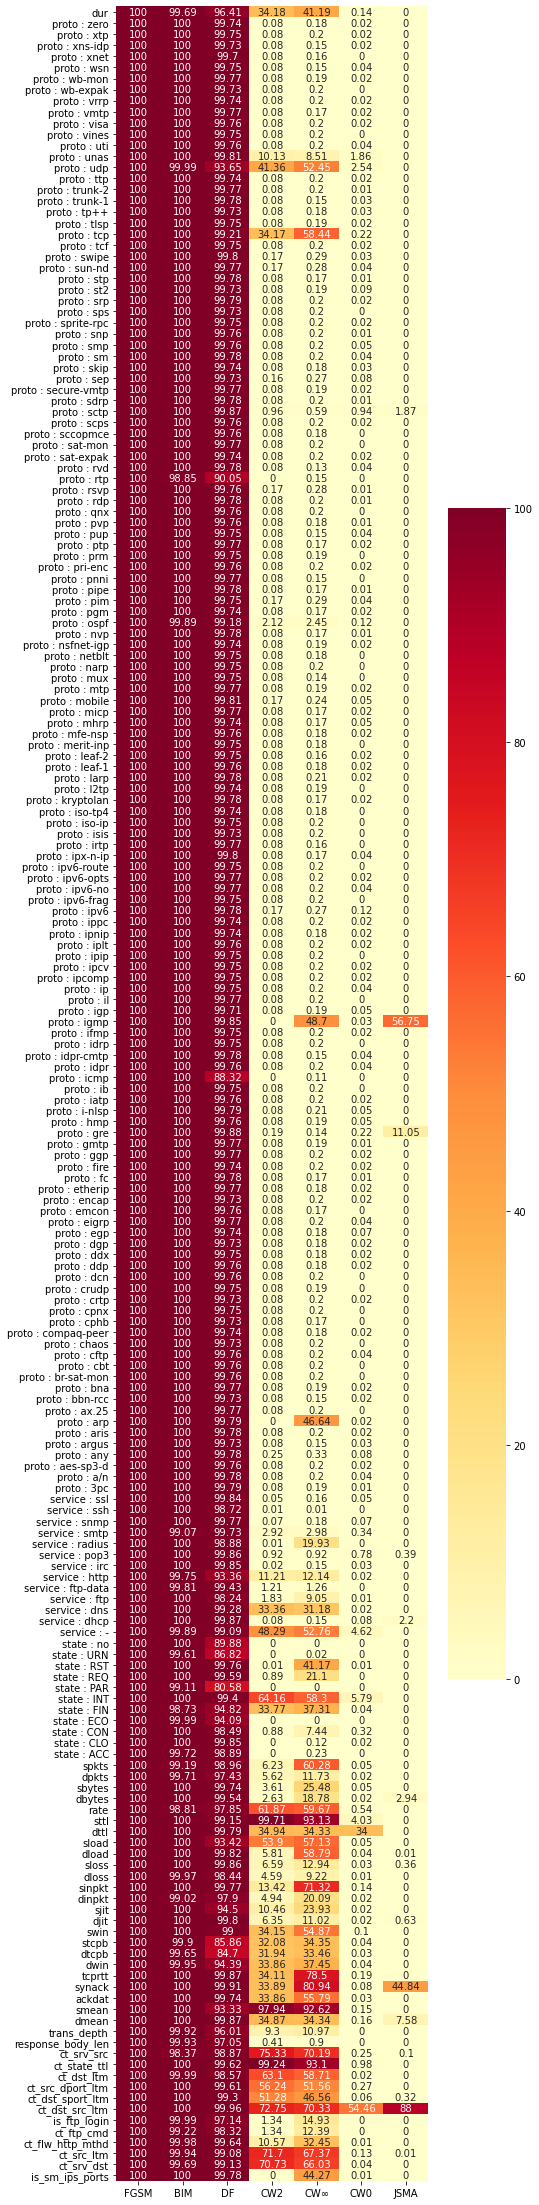

In [106]:
fig, ax = plt.subplots(figsize=(7,40))

sb.heatmap(adv_feat_stats.round(decimals=2), annot=True, cmap='YlOrRd', fmt='g')

plt.savefig("hmap_features_stats.eps", format="eps", bbox_inches='tight')
plt.show()

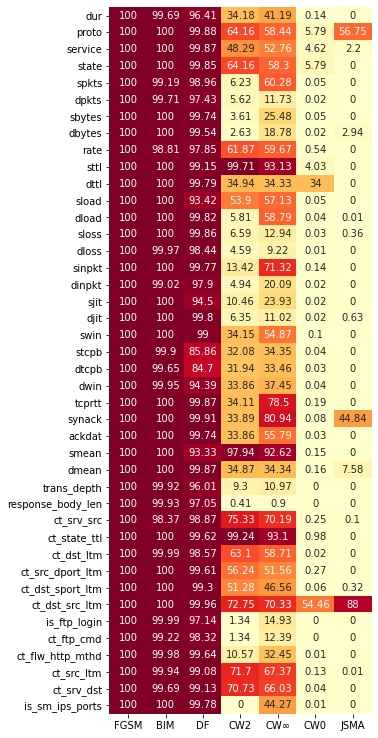

In [179]:
adv_feat_stats_cat = adv_feat_stats

f2 = adv_feat_stats_cat.iloc[1:134].max()
f3 = adv_feat_stats_cat.iloc[134:147].max()
f4 = adv_feat_stats_cat.iloc[147:158].max()

adv_feat_stats_cat.iloc[1] = [f2[0], f2[1], f2[2], f2[3], f2[4], f2[5], f2[6]]
adv_feat_stats_cat.index.values[1] = 'proto'
adv_feat_stats_cat.iloc[2] = [f3[0], f3[1], f3[2], f3[3], f3[4], f3[5], f3[6]]
adv_feat_stats_cat.index.values[2] = 'service'
adv_feat_stats_cat.iloc[3] = [f4[0], f4[1], f4[2], f4[3], f4[4], f4[5], f4[6]]
adv_feat_stats_cat.index.values[3] = 'state'
adv_feat_stats.drop(axis=0, index=adv_feat_stats_cat.index[4:158], inplace=True)

fig, ax = plt.subplots(figsize=(4.7,13))


sb.heatmap(adv_feat_stats.round(decimals=2), annot=True, cmap='YlOrRd', fmt='g', cbar=False)

plt.savefig("hmap_features_stats.eps", format="eps", bbox_inches='tight')
plt.show()


In [107]:
adv_inv.to_csv("./adv_inv")
adv_inv

,Clean,FGSM,BIM,DF,CW2,CW∞,CW0,JSMA
Invalid value range,0.0,100.0,100.0,100.0,99.554982,93.156276,32.779645,6.520227
Invalid binary values,0.0,100.0,100.0,100.0,99.978210,93.381718,15.199336,68.327453
Invalid class belonging,0.0,100.0,100.0,100.0,0.000000,48.832142,0.028495,68.327453


## Features analysis

### Heat map of the correlation matrix

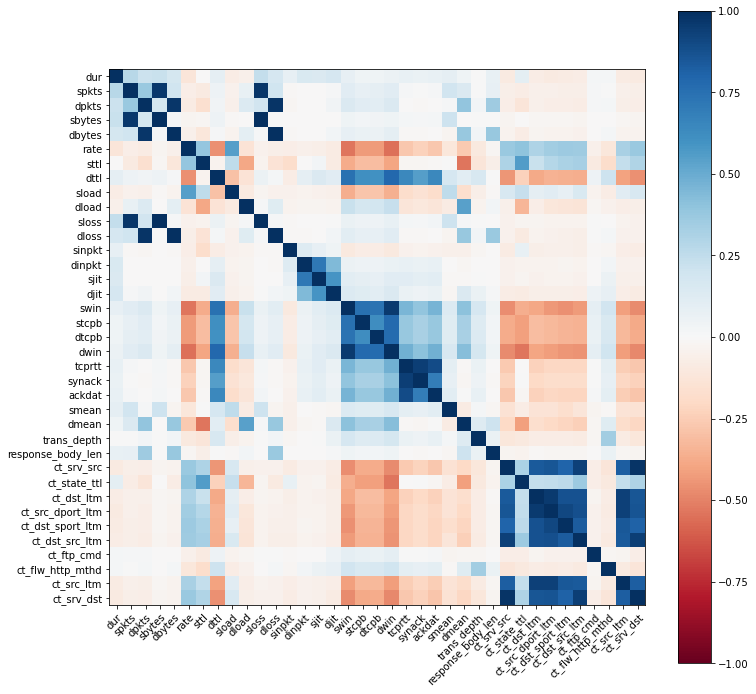

In [13]:
numeric_features = ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload',
       'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin',
       'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean',
       'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src',
       'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
       'ct_dst_src_ltm', 'ct_ftp_cmd', 'ct_flw_http_mthd',
       'ct_src_ltm', 'ct_srv_dst']
corr = df_training[numeric_features].corr()

fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(corr, cmap='RdBu', vmin=-1, vmax=1)

ax.figure.colorbar(im)
plt.yticks(np.arange(0, len(corr.columns), 1), corr.columns)
plt.xticks(np.arange(0, len(corr.columns), 1), corr.columns, rotation=45, ha="right", rotation_mode="anchor")

#for i in range(len(numeric_features)):
#    for j in range(len(numeric_features)):
#        text = ax.text(j, i, corr.iloc[i, j].round(decimals=1), ha="center", va="center", color="w")

plt.savefig('correlation_matrix.eps', format='eps', bbox_inches='tight')  
plt.show()